In [1]:
import pandas as pd
import requests
import json
from selectolax.parser import HTMLParser

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


Загружаю посты с сайта Яндекс Недвижимость. Почему код выглядит странно и костыльно:

1. Когда вы ищете квартиру к покупке, пусть на сайте хоть 50 тыс. объявлений, вы сможете долистать только до 25 страницы - далее их не существует.

    На одной странице ~20 объявлений. 500 != 50 тыс. Звучит как очень малый датасет в 500 квартир для СПБ (- _-)


2. Решение - играться с тегами. Сегментирование дает результат: у нас всё тот же лимит в 25 страниц, но для каждого тега отдельно.


3. Для этого есть массив url ссылок - разбиение по тегам вторичный рынок\новостройка, количество комнат.


4. В функции load_posts происходит подгрузка словарей-объявлений в общий массив, с которым будем работать позднее. 

    В ней так же особым образом реализован шаг - опять же отсылаясь к лимиту в 25 страниц


5. Шаг помогает контролировать третий критерий - ценовой диапазон. 

    Причём шаг различный для разных сумм: однокомнатных квартир очень много в диапазоне 5 млн - 9 млн, а вне диапазона их плотность на отрезке цены уменьшается


6. Обработка и загрузка постов сделана для разных url в отдельных блоках, порциями - оперативная память даёт о себе знать и крашит моё ssh соединение (wsl тоже страдает).

    Также сохранение происходит сразу же в отдельные csv файлы, впоследствии будут объединены

7. Почему нет заимстованного датасета - найденные устарели. Оценивать сегодняшнюю недвижку по датасетам двухгодичной давности не звучит как хорошее занятие

In [16]:
offers = []
urls_partitial_offers = ['https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/studiya/vtorichniy-rynok/', 
                         'https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/studiya/novostroyki/',
                         'https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/odnokomnatnaya/vtorichniy-rynok/',
                         'https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/odnokomnatnaya/novostroyki/',
                         'https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/dvuhkomnatnaya/novostroyki/',
                         'https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/dvuhkomnatnaya/vtorichniy-rynok/',
                         'https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/tryohkomnatnaya/vtorichniy-rynok/',
                         'https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/tryohkomnatnaya/novostroyki/',
                         'https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/4-i-bolee/vtorichniy-rynok/',
                         'https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/4-i-bolee/novostroyki/']

def load_posts(url):
    minPrice = 500_000
    maxPrice = 500_000
    step = 500_000
    for i in range(0, 100):
        minPrice += step
        maxPrice = minPrice + step - 1
        if i == 6:
            step = 250_000
        if i == 50:
            step = 1_000_000
        if i == 70:
            maxPrice = 1_000_000_000
        if i == 71:
            break
        page = 1
        if (i % 10 == 0):
            print(str(i) + ' step')
        while True:
            params = (('page', page), ('priceMin', minPrice), ('priceMax', maxPrice))
            response = requests.get(url, params=params)
            response.encoding = 'utf-8'

            html = response.text
            tree = HTMLParser(html)

            if not (tree.css_first('script[id="initial_state_script"]')):
                break

            script = tree.css_first('script[id="initial_state_script"]').text()
            script = script[23:-1]

            data = json.loads(script)
            offers.extend(data['map']['offers']['points'])
            page += 1

    print(url, 'done')

In [17]:
load_posts(urls_partitial_offers[0])

0 step
10 step
20 step
30 step
40 step
50 step
60 step
70 step
https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/studiya/vtorichniy-rynok/ done


In [18]:
apartments_data = []

In [19]:
def get_data_from_offers(offers):
    apartments_data.clear()
    for offer in offers:
        if not offer.get('floorsOffered'):
            continue
        apartment = {
            'id': offer.get('offerId'),
            'price': offer['price'].get('value'),
            'area': offer['area'].get('value'),
            'rooms': offer.get('roomsTotalKey'),
            'ceilingHeight': offer.get('ceilingHeight'),
            'kitchen_space': offer['kitchenSpace'].get('value') if 'kitchenSpace' in offer else 'studio',
            'floor': offer.get('floorsOffered')[0],
            'floorsTotal': offer.get('floorsTotal'),
            'creationDate': offer.get('creationDate'),
            'seller': offer['author'].get('category'),
            'address': offer['location'].get('geocoderAddress'),
            'nearest_metro': offer['location']['metro']['name'] if 'metro' in offer['location'] else None,
            'time_to_metro': offer['location']['metro'].get('minTimeToMetro') if 'metro' in offer['location'] else None,
            'transport_to_metro': offer['location']['metro'].get('metroTransport') if 'metro' in offer['location'] else None,
            'branch_metro_color': offer['location']['metro'].get('lineColors')[0] if 'metro' in offer['location'] else None,
            'parks_count': len(offer['location'].get('parks')) if 'parks' in offer['location'] else 0,
            'nearest_park': offer['location']['parks'][0].get('name') if 'parks' in offer['location'] else None,
            'time_park': offer['location']['parks'][0].get('timeOnFoot') if 'parks' in offer['location'] else None,
            'distance_park': offer['location']['parks'][0].get('distanceOnFoot') if 'parks' in offer['location'] else None,
            'ponds_count': len(offer['location'].get('ponds')) if 'ponds' in offer['location'] else 0,
            'nearest_pond': offer['location']['ponds'][0].get('name') if 'ponds' in offer['location'] else None,
            'time_pond': offer['location']['ponds'][0].get('timeOnFoot') if 'ponds' in offer['location'] else None,
            'distance_pond': offer['location']['ponds'][0].get('distanceOnFoot') if 'ponds' in offer['location'] else None,
            'nearest_airport': offer['location']['airports'][0].get('name') if 'airports' in offer['location'] else None,
            'time_airport_via_car': offer['location']['airports'][0].get('timeOnCar') if 'airports' in offer['location'] else None,
            'distance_airport': offer['location']['airports'][0].get('distanceOnCar') if 'airports' in offer['location'] else None,
            'images': offer.get('large1242Images')
        }
        apartments_data.append(apartment)

In [20]:
get_data_from_offers(offers)

In [21]:
df = pd.DataFrame(apartments_data)
df.shape

(15718, 27)

In [30]:
df.sample(5)
# df.head()

,id,price,area,rooms,ceilingHeight,kitchen_space,floor,floorsTotal,creationDate,seller,...,time_park,distance_park,ponds_count,nearest_pond,time_pond,distance_pond,nearest_airport,time_airport_via_car,distance_airport,images
15686,149435909235188927,43900000,140.10,studio,3.0,studio,3,4,2025-04-25T15:52:38Z,AGENCY,...,548.0,743.0,3,Среднее Суздальское озеро,0.0,57.0,Пулково,3484.0,44433.0,[//avatars.mds.yandex.net/get-realty-offers/11...
214,5279600861237375865,3450000,10.90,studio,2.6,studio,1,6,2025-02-01T11:30:53Z,AGENCY,...,465.0,642.0,0,None,NaN,NaN,Пулково,2307.0,24179.0,[//avatars.mds.yandex.net/get-realty-offers/13...
2387,8898868126694160800,5150000,26.50,studio,2.7,studio,22,24,2025-04-11T12:32:55Z,AGENCY,...,NaN,NaN,1,река Утка,120.0,214.0,Пулково,1723.0,21567.0,[//avatars.mds.yandex.net/get-realty-offers/13...
15253,5073293347945329665,16700000,46.00,studio,NaN,studio,10,20,2024-07-09T07:23:16Z,OWNER,...,313.0,538.0,0,None,NaN,NaN,Пулково,2119.0,20783.0,[//avatars.mds.yandex.net/get-verba/787013/2a0...
5123,5871497920636674816,5800000,24.75,studio,2.7,studio,12,13,2024-04-03T12:12:24Z,AGENCY,...,244.0,342.0,1,Ивановский карьер,120.0,175.0,Пулково,2024.0,20279.0,[//avatars.mds.yandex.net/get-realty-offers/11...


<b>Яндекс Недвижимость очень любит даже с фильтрами на цены давать предложения вне ценового фильтра с надписями "На 100 тысяч дешевле". Дупликатов куча. 

Удаляем сразу же</b>

In [25]:
df.duplicated(subset=['id']).sum()

np.int64(12503)

In [26]:
df.drop_duplicates(subset=['id'], inplace=True)

In [27]:
df.duplicated(subset=['id']).sum(), df.shape[0]

(np.int64(0), 3215)

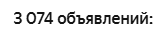

Почти сходиться со значением, указанным на сайте для студий на вторичке - можно брать

In [28]:
df.to_csv('0.csv', index=False)

In [29]:
offers.clear()
print(len(offers))

0


Всё то же проделываем с остальными ссылками

In [31]:
load_posts(urls_partitial_offers[1])

0 step
10 step
20 step
30 step
40 step
50 step
60 step
70 step
https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/studiya/novostroyki/ done


In [32]:
get_data_from_offers(offers)
df = pd.DataFrame(apartments_data)
print(df.shape)
print(df.duplicated(subset=['id']).sum())
df.drop_duplicates(subset=['id'],inplace=True)
print(df.duplicated(subset=['id']).sum(), df.shape[0])
df.to_csv('1.csv', index=False)

(22116, 27)
14910
0 7206


In [33]:
offers.clear()

In [34]:
load_posts(urls_partitial_offers[2])

0 step
10 step
20 step
30 step
40 step
50 step
60 step
70 step
https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/odnokomnatnaya/vtorichniy-rynok/ done


In [35]:
get_data_from_offers(offers)
df = pd.DataFrame(apartments_data)
print(df.shape)
print(df.duplicated(subset=['id']).sum())
df.drop_duplicates(subset=['id'],inplace=True)
print(df.duplicated(subset=['id']).sum(), df.shape[0])
df.to_csv('2.csv', index=False)

(27295, 27)
21958
0 5337


In [36]:
offers.clear()

In [37]:
load_posts(urls_partitial_offers[3])

0 step
10 step
20 step
30 step
40 step
50 step
60 step
70 step
https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/odnokomnatnaya/novostroyki/ done


In [38]:
get_data_from_offers(offers)
df = pd.DataFrame(apartments_data)
print(df.shape)
print(df.duplicated(subset=['id']).sum())
df.drop_duplicates(subset=['id'],inplace=True)
print(df.duplicated(subset=['id']).sum(), df.shape[0])
df.to_csv('3.csv', index=False)

(30319, 27)
19058
0 11261


In [39]:
offers.clear()

In [40]:
load_posts(urls_partitial_offers[4])

0 step
10 step
20 step
30 step
40 step
50 step
60 step
70 step
https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/dvuhkomnatnaya/novostroyki/ done


In [41]:
get_data_from_offers(offers)
df = pd.DataFrame(apartments_data)
print(df.shape)
print(df.duplicated(subset=['id']).sum())
df.drop_duplicates(subset=['id'],inplace=True)
print(df.duplicated(subset=['id']).sum(), df.shape[0])
df.to_csv('4.csv', index=False)

(28560, 27)
20436
0 8124


In [42]:
offers.clear()

In [43]:
load_posts(urls_partitial_offers[5])

0 step
10 step
20 step
30 step
40 step
50 step
60 step
70 step
https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/dvuhkomnatnaya/vtorichniy-rynok/ done


In [44]:
get_data_from_offers(offers)
df = pd.DataFrame(apartments_data)
print(df.shape)
print(df.duplicated(subset=['id']).sum())
df.drop_duplicates(subset=['id'],inplace=True)
print(df.duplicated(subset=['id']).sum(), df.shape[0])
df.to_csv('5.csv', index=False)

(31265, 27)
25616
0 5649


In [45]:
offers.clear()

In [46]:
load_posts(urls_partitial_offers[6])

0 step
10 step
20 step
30 step
40 step
50 step
60 step
70 step
https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/tryohkomnatnaya/vtorichniy-rynok/ done


In [47]:
get_data_from_offers(offers)
df = pd.DataFrame(apartments_data)
print(df.shape)
print(df.duplicated(subset=['id']).sum())
df.drop_duplicates(subset=['id'],inplace=True)
print(df.duplicated(subset=['id']).sum(), df.shape[0])
df.to_csv('6.csv', index=False)

(28901, 27)
24733
0 4168


In [48]:
offers.clear()

In [49]:
load_posts(urls_partitial_offers[7])

0 step
10 step
20 step
30 step
40 step
50 step
60 step
70 step
https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/tryohkomnatnaya/novostroyki/ done


In [50]:
get_data_from_offers(offers)
df = pd.DataFrame(apartments_data)
print(df.shape)
print(df.duplicated(subset=['id']).sum())
df.drop_duplicates(subset=['id'],inplace=True)
print(df.duplicated(subset=['id']).sum(), df.shape[0])
df.to_csv('7.csv', index=False)

(20067, 27)
16753
0 3314


In [51]:
offers.clear()

In [52]:
load_posts(urls_partitial_offers[8])

0 step
10 step
20 step
30 step
40 step
50 step
60 step
70 step
https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/4-i-bolee/vtorichniy-rynok/ done


In [53]:
get_data_from_offers(offers)
df = pd.DataFrame(apartments_data)
print(df.shape)
print(df.duplicated(subset=['id']).sum())
df.drop_duplicates(subset=['id'],inplace=True)
print(df.duplicated(subset=['id']).sum(), df.shape[0])
df.to_csv('8.csv', index=False)

(7676, 27)
6299
0 1377


In [54]:
offers.clear()

In [55]:
load_posts(urls_partitial_offers[9])

0 step
10 step
20 step
30 step
40 step
50 step
60 step
70 step
https://realty.yandex.ru/sankt-peterburg/kupit/kvartira/4-i-bolee/novostroyki/ done


In [56]:
get_data_from_offers(offers)
df = pd.DataFrame(apartments_data)
print(df.shape)
print(df.duplicated(subset=['id']).sum())
df.drop_duplicates(subset=['id'],inplace=True)
print(df.duplicated(subset=['id']).sum(), df.shape[0])
df.to_csv('9.csv', index=False)

(1466, 27)
1128
0 338


In [57]:
offers.clear()

Соединим csv

In [58]:
names_csv = [str(i)+'.csv' for i in range(0, 10)]
names_csv

['0.csv',
 '1.csv',
 '2.csv',
 '3.csv',
 '4.csv',
 '5.csv',
 '6.csv',
 '7.csv',
 '8.csv',
 '9.csv']

In [59]:
df = pd.concat([pd.read_csv(f) for f in names_csv], ignore_index=True)
df.shape

(49989, 27)

In [60]:
df.to_csv("data.csv", index=False)